In [30]:
from pathlib import Path

import requests
from tqdm import tqdm

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import altair as alt

In [31]:
sns.set_style('white')

alt.themes.enable('default')
alt.renderers.enable('kaggle')
alt.renderers.set_embed_options(actions=False)
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [33]:
listings_detail_df = pd.read_csv('../data/listings.csv', low_memory=False,
                                 parse_dates=['host_since', 
                                              'last_scraped', 'calendar_last_scraped',
                                              'first_review', 'last_review'])

listings_detail_df.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,11551,https://www.airbnb.com/rooms/11551,20191105115249,2019-11-06,Arty and Bright London Apartment in Zone 2,Unlike most rental apartments out there my fla...,"Amenities Bedding: 1 Double bed, 1 living room...",Unlike most rental apartments out there my fla...,family,Not even 10 minutes by metro from Victoria Sta...,...,t,f,strict_14_with_grace_period,f,t,2,2,0,0,1.58
1,38151,https://www.airbnb.com/rooms/38151,20191105115249,2019-11-06,Double room/ lounge,NaN,"Comfortable, large double room /lounge area av...","Comfortable, large double room /lounge area av...",none,NaN,...,f,f,flexible,f,f,1,0,1,0,NaN
2,13913,https://www.airbnb.com/rooms/13913,20191105115249,2019-11-06,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,...,f,f,moderate,f,f,2,1,1,0,0.17


In [34]:
columns=['id','number_of_reviews','last_review','host_since','reviews_per_month']
scores = ['review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
               'review_scores_communication', 'review_scores_location', 'review_scores_value']

listings_detail_df=listings_detail_df[columns+scores]
listings_detail_df.head(2)

,id,number_of_reviews,last_review,host_since,reviews_per_month,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
0,11551,185,2019-09-15,2009-10-03,1.58,9.0,9.0,10.0,10.0,9.0,9.0
1,38151,0,NaT,2010-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


可以发现总评论数为0的房源其余特征也为空，符合情理；一方面有可能是平台的试验房源；另一方面可能是用户的测试房源；**该类单独成一类。不参与我们的RFM模型！**

经过检验，评论数越多，缺失值越少，符合常理。

In [35]:
listings_detail_df[listings_detail_df['number_of_reviews']==0]

,id,number_of_reviews,last_review,host_since,reviews_per_month,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
1,38151,0,NaT,2010-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,38950,0,NaT,2010-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,38995,0,NaT,2010-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,40228,0,NaT,2010-07-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,96008,0,NaT,2011-04-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,96640,0,NaT,2011-04-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,42692,0,NaT,2010-07-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,208952,0,NaT,2011-08-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,46491,0,NaT,2010-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,46511,0,NaT,2010-08-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
listings_detail_df['number_of_reviews'].describe()

count    85068.000000
mean        17.471152
std         36.789578
min          0.000000
25%          1.000000
50%          4.000000
75%         17.000000
max        716.000000
Name: number_of_reviews, dtype: float64

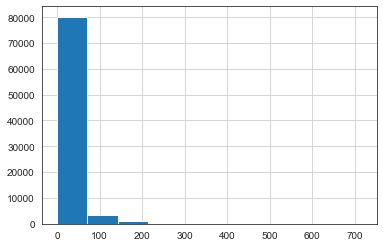

In [37]:
listings_detail_df['number_of_reviews'].hist()

筛选出总评论数非0的房源数据

In [38]:
listings_detail_df=listings_detail_df[listings_detail_df['number_of_reviews']!=0]

listings_detail_df.reset_index(drop=True, inplace=True)
listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65062 entries, 0 to 65061
Data columns (total 11 columns):
id                             65062 non-null int64
number_of_reviews              65062 non-null int64
last_review                    65062 non-null datetime64[ns]
host_since                     65059 non-null datetime64[ns]
reviews_per_month              65062 non-null float64
review_scores_accuracy         63391 non-null float64
review_scores_cleanliness      63405 non-null float64
review_scores_checkin          63343 non-null float64
review_scores_communication    63399 non-null float64
review_scores_location         63345 non-null float64
review_scores_value            63344 non-null float64
dtypes: datetime64[ns](2), float64(7), int64(2)
memory usage: 5.5 MB


将时间特征last_review+host_since转换为距‘2019-11-05’的天数

In [46]:
listings_detail_df['last_review_day']=(pd.Timestamp('2019-11-05') - listings_detail_df['last_review']).dt.days
listings_detail_df['host_since_day']=(pd.Timestamp('2019-11-05') - listings_detail_df['host_since']).dt.days

In [54]:
listings_detail_df=listings_detail_df.drop(['last_review','host_since'],axis=1)
listings_detail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65062 entries, 0 to 65061
Data columns (total 11 columns):
id                             65062 non-null int64
number_of_reviews              65062 non-null int64
reviews_per_month              65062 non-null float64
review_scores_accuracy         63391 non-null float64
review_scores_cleanliness      63405 non-null float64
review_scores_checkin          63343 non-null float64
review_scores_communication    63399 non-null float64
review_scores_location         63345 non-null float64
review_scores_value            63344 non-null float64
last_review_day                65062 non-null int64
host_since_day                 65059 non-null float64
dtypes: float64(8), int64(3)
memory usage: 5.5 MB


利用无缺失的数据备份看看各数值特征间的相关性,以便决定除了得分之外，该选择那些特征进入RFM模型

In [55]:
test=listings_detail_df.copy()

test=test.dropna()

test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63318 entries, 0 to 65061
Data columns (total 11 columns):
id                             63318 non-null int64
number_of_reviews              63318 non-null int64
reviews_per_month              63318 non-null float64
review_scores_accuracy         63318 non-null float64
review_scores_cleanliness      63318 non-null float64
review_scores_checkin          63318 non-null float64
review_scores_communication    63318 non-null float64
review_scores_location         63318 non-null float64
review_scores_value            63318 non-null float64
last_review_day                63318 non-null int64
host_since_day                 63318 non-null float64
dtypes: float64(8), int64(3)
memory usage: 5.8 MB


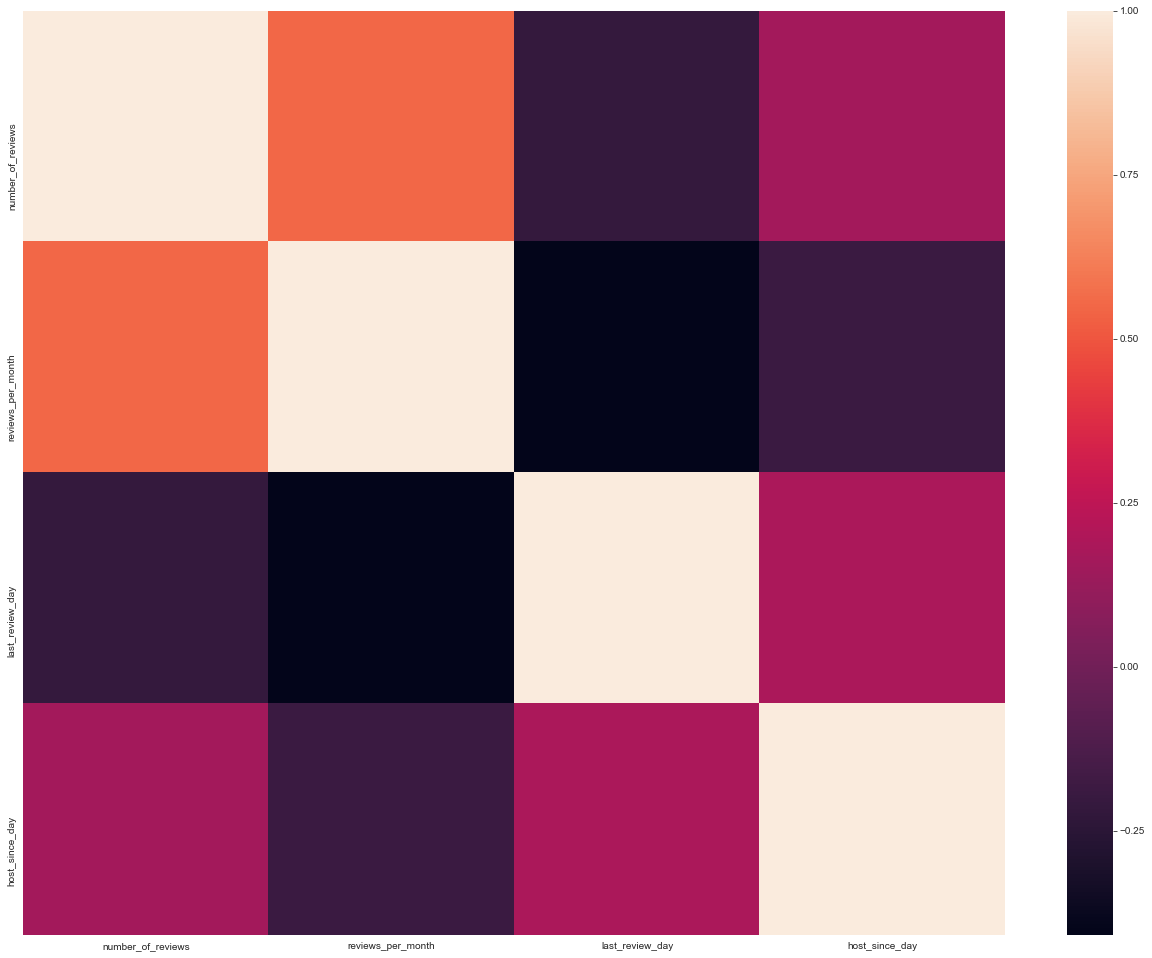

In [59]:
test=test[['number_of_reviews','reviews_per_month','last_review_day','host_since_day']]
scores=test.corr(method='pearson', min_periods=1) 
plt.figure(figsize=(22,17))   #用这个能控制图的大小
sns.heatmap(scores)

均无明显相关性...

根据业务理解：决定还是选择 ‘number_of_reviews’+‘last_review_day’+‘得分’

在探索性分析中我们得知，评分特征中除了位置评分外，其余评分都有着很强的正相关性,原本想利用这一点填补缺失值，结果发现这些评分都是要么一起无缺失，要么一起全缺失...，改变策略：因为缺失值数量不多，用均值填充

In [60]:
for column in list(listings_detail_df.columns[listings_detail_df.isnull().sum() > 0]):
    mean_val = listings_detail_df[column].mean()
    listings_detail_df[column].fillna(mean_val, inplace=True)

In [61]:
listings_detail_df['score']=( listings_detail_df['review_scores_accuracy']+listings_detail_df['review_scores_cleanliness']
                               +listings_detail_df['review_scores_checkin']+listings_detail_df['review_scores_communication']
                               +listings_detail_df['review_scores_value']+listings_detail_df['review_scores_location'])/6

In [62]:
listings_detail_df.head()

,id,number_of_reviews,reviews_per_month,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,last_review_day,host_since_day,score
0,11551,185,1.58,9.0,9.0,10.0,10.0,9.0,9.0,51,3685.0,9.333333
1,13913,19,0.17,10.0,10.0,10.0,10.0,9.0,9.0,29,3641.0,9.666667
2,38407,137,1.23,9.0,10.0,10.0,10.0,9.0,9.0,928,3403.0,9.500000
3,90700,339,3.33,9.0,9.0,10.0,10.0,10.0,9.0,98,3134.0,9.500000
4,15400,88,0.73,10.0,10.0,10.0,10.0,10.0,9.0,43,3622.0,9.833333


In [63]:
RFM=listings_detail_df[['id','last_review_day','number_of_reviews','score']]

RFM=RFM.rename(columns={'last_review_day':'r','number_of_reviews':'f','score':'m'}) 

RFM.head(2)

,id,r,f,m
0,11551,51,185,9.333333
1,13913,29,19,9.666667


减去各自均值

In [64]:
RFM.r = RFM.r -RFM.r.mean(axis=0)
RFM.f = RFM.f -RFM.f.mean(axis=0)
RFM.m = RFM.m -RFM.m.mean(axis=0)

RFM.head(2)

,id,r,f,m
0,11551,-190.919262,162.15662,-0.141924
1,13913,-212.919262,-3.84338,0.191409


In [67]:
RFM['R']=RFM['r'].map(lambda a : 1 if a<0 else 0)

RFM['F']=RFM['f'].map(lambda a : 1 if a>0 else 0)

RFM['M']=RFM['m'].map(lambda a : 1 if a>0 else 0)

RFM.head(2)

,id,r,f,m,R,F,M
0,11551,-190.919262,162.15662,-0.141924,1,1,0
1,13913,-212.919262,-3.84338,0.191409,1,0,1


In [72]:
RFM['text']=RFM['R'].map(str)+RFM['F'].map(str)+RFM['M'].map(str)
RFM.head(2)

,id,r,f,m,R,F,M,text
0,11551,-190.919262,162.15662,-0.141924,1,1,0,110
1,13913,-212.919262,-3.84338,0.191409,1,0,1,101


In [73]:
def trans(number):
    if number == '111':
        return '重要价值房源'
    elif number == '110':
        return '一般价值房源'
    elif number == '101':
        return '重要发展房源'
    elif number == '011':
        return '重要保持房源'
    elif number == '100':
        return '一般发展房源'
    elif number == '010':
        return '一般保持房源'
    elif number == '001':
        return '重要挽留房源'
    else:
        return '一般挽留房源'

RFM['类别'] = RFM['text'].map(trans)
RFM.head(2)

,id,r,f,m,R,F,M,text,类别
0,11551,-190.919262,162.15662,-0.141924,1,1,0,110,一般价值房源
1,13913,-212.919262,-3.84338,0.191409,1,0,1,101,重要发展房源


In [75]:
RFM=RFM[['id','类别']]

RFM.to_csv('RFM.csv',index=0)